In [1]:
""" Inspired by example from
https://github.com/Vict0rSch/deep_learning/tree/master/keras/recurrent
Uses the TensorFlow backend
The basic idea is to detect anomalies in a time-series.

https://github.com/sushilshah/lstm-anomaly-detect/blob/master/lstm-synthetic-wave-anomaly-detect.py

"""
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from numpy import arange, sin, pi, random

C:\Users\sushil.shah\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
np.random.seed(1234)

# Global hyper-parameters
sequence_length = 100
random_data_dup = 10  # each sample randomly duplicated between 0 and 9 times, see dropin function
epochs = 1
batch_size = 50

In [3]:
def dropin(X, y):
    """ The name suggests the inverse of dropout, i.e. adding more samples. See Data Augmentation section at
    http://simaaron.github.io/Estimating-rainfall-from-weather-radar-readings-using-recurrent-neural-networks/
    :param X: Each row is a training sequence
    :param y: Tne target we train and will later predict
    :return: new augmented X, y
    """
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    X_hat = []
    y_hat = []
    for i in range(0, len(X)):
        for j in range(0, np.random.random_integers(0, random_data_dup)):
            X_hat.append(X[i, :])
            y_hat.append(y[i])
    return np.asarray(X_hat), np.asarray(y_hat)


def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise
    :return: the final wave
    """
    t = np.arange(0.0, 10.0, 0.01)
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.8 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    return wave1 + wave2


def z_norm(result):
    result_mean = result.mean()
    result_std = result.std()
    result -= result_mean
    result /= result_std
    return result, result_mean


def get_split_prep_data(train_start, train_end,
                          test_start, test_end):
    data = gen_wave()
    print("Length of Data", len(data))

    # train data
    print ("Creating train data...")

    result = []
    for index in range(train_start, train_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of train data : ", result_mean)
    print ("Train data shape  : ", result.shape)

    train = result[train_start:train_end, :]
    np.random.shuffle(train)  # shuffles in-place
    X_train = train[:, :-1]
    y_train = train[:, -1]
    X_train, y_train = dropin(X_train, y_train)

    # test data
    print ("Creating test data...")

    result = []
    for index in range(test_start, test_end - sequence_length):
        result.append(data[index: index + sequence_length])
    result = np.array(result)  # shape (samples, sequence_length)
    result, result_mean = z_norm(result)

    print ("Mean of test data : ", result_mean)
    print ("Test data shape  : ", result.shape)

    X_test = result[:, :-1]
    y_test = result[:, -1]

    print("Shape X_train", np.shape(X_train))
    print("Shape X_test", np.shape(X_test))

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_train, y_train, X_test, y_test


In [4]:
def build_model():
    model = Sequential()
    layers = {'input': 1, 'hidden1': 64, 'hidden2': 256, 'hidden3': 100, 'output': 1}

    model.add(LSTM(
            input_length=sequence_length - 1,
            input_dim=layers['input'],
            output_dim=layers['hidden1'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden2'],
            return_sequences=True))
    model.add(Dropout(0.2))

    model.add(LSTM(
            layers['hidden3'],
            return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(
            output_dim=layers['output']))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="rmsprop")
    print ("Compilation Time : ", time.time() - start)
    return model


In [5]:
def run_network(model=None, data=None):
    global_start_time = time.time()

    if data is None:
        print ('Loading data... ')
        # train on first 700 samples and test on next 300 samples (has anomaly)
        X_train, y_train, X_test, y_test = get_split_prep_data(0, 700, 500, 1000)
    else:
        X_train, y_train, X_test, y_test = data

    print ('\nData Loaded. Compiling...\n')

    if model is None:
        model = build_model()

    try:
        print("Training...")
#         UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
#   warnings.warn('The `nb_epoch` argument in `fit` '
        model.fit(
                X_train, y_train,
                batch_size=batch_size, nb_epoch=epochs, validation_split=0.05)
        print("Predicting...")
        predicted = model.predict(X_test)
        print("Reshaping predicted")
        predicted = np.reshape(predicted, (predicted.size,))
    except KeyboardInterrupt:
        print("prediction exception")
        print ('Training duration (s) : ', time.time() - global_start_time)
        return model, y_test, 0

    try:
        plt.figure(1)
        plt.subplot(311)
        plt.title("Actual Test Signal w/Anomalies")
        plt.plot(y_test[:len(y_test)], 'b')
        plt.subplot(312)
        plt.title("Predicted Signal")
        plt.plot(predicted[:len(y_test)], 'g')
        plt.subplot(313)
        plt.title("Squared Error")
        mse = ((y_test - predicted) ** 2)
        plt.plot(mse, 'r')
        plt.show()
    except Exception as e:
        print("plotting exception")
        print (str(e))
    print ('Training duration (s) : ', time.time() - global_start_time)

    return model, y_test, predicted

Loading data... 
wave1 1000
wave2 1000
wave3 50
Length of Data 1000
Creating train data...
Mean of train data :  0.0017174984265156412
Train data shape  :  (600, 100)
X shape: (600, 99)
y shape: (600,)
Creating test data...
Mean of test data :  0.01647475124693149
Test data shape  :  (400, 100)
Shape X_train (2958, 99)
Shape X_test (400, 99)

Data Loaded. Compiling...



C:\Users\sushil.shah\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: This function is deprecated. Please call randint(0, 10 + 1) instead
  del sys.path[0]
C:\Users\sushil.shah\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  if __name__ == '__main__':
C:\Users\sushil.shah\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(return_sequences=True, input_shape=(99, 1), units=64)`
  if __name__ == '__main__':
C:\Users\sushil.shah\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(units=1)`
C:\Users\sushil.shah\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argume

Compilation Time :  0.03860878944396973
Training...
Train on 2810 samples, validate on 148 samples
Epoch 1/1
2810/2810 [==============================] - 59s 21ms/step - loss: 0.1648 - val_loss: 0.6042
Predicting...
Reshaping predicted


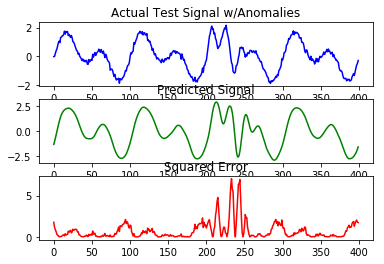

Training duration (s) :  67.43919062614441


(<keras.models.Sequential at 0x1aea81b4a90>,
 array([-0.03234027, -0.01299899,  0.17696021,  0.37163726,  0.48932391,
         0.72637937,  0.93782884,  1.04655172,  0.94511579,  1.30762295,
         1.3353632 ,  1.4208764 ,  1.43421399,  1.52626842,  1.74629737,
         1.54415277,  1.72848576,  1.69945324,  1.72272295,  1.44364595,
         1.52105484,  1.40199673,  1.30996643,  1.44608385,  1.30062824,
         1.02082758,  0.9835917 ,  0.86424928,  0.68650609,  0.53685679,
         0.3906353 ,  0.35000351,  0.13917691,  0.19648548, -0.00479065,
        -0.08431134, -0.17570223, -0.30625616, -0.19783829, -0.34507165,
        -0.2823547 , -0.39815058, -0.32381145, -0.29085709, -0.55892524,
        -0.56973171, -0.23815655, -0.39330687, -0.29637955, -0.23046068,
        -0.29481457,  0.13347121, -0.06621533,  0.12090256,  0.25305059,
         0.05574722,  0.20679014,  0.270261  ,  0.33594441,  0.48777563,
         0.39347172,  0.27181453,  0.46373086,  0.31536627,  0.19971596,
      

In [6]:
run_network()

In [22]:
def gen_wave():
    """ Generate a synthetic wave by adding up a few sine waves and some noise
    :return: the final wave
    """
    t = np.arange(0.0, 10.0, 0.01)

    print("len of t: ", len(t))
    wave1 = sin(2 * 2 * pi * t)
    noise = random.normal(0, 0.1, len(t))
    wave1 = wave1 + noise
    print("wave1", len(wave1))
    wave2 = sin(2 * pi * t)
    print("wave2", len(wave2))
    t_rider = arange(0.0, 0.5, 0.01)
    wave3 = sin(10 * pi * t_rider)
    print("wave3", len(wave3))
    insert = round(0.8 * len(t))
    wave1[insert:insert + 50] = wave1[insert:insert + 50] + wave3
    return wave1 + wave2

len of t:  1000
wave1 1000
wave2 1000
wave3 50
len of t:  1000
wave1 1000
wave2 1000
wave3 50


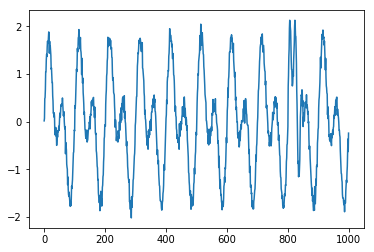

In [26]:
foo = gen_wave()
plt.plot(foo)
bar = gen_wave()

In [28]:
foo

array([ 1.49002153e-02,  6.76547870e-02,  4.81213901e-01,  5.04044259e-01,
        6.75118378e-01,  1.04526698e+00,  1.04685659e+00,  1.30171305e+00,
        1.41091703e+00,  1.36682494e+00,  1.57119569e+00,  1.68522445e+00,
        1.65074856e+00,  1.64361859e+00,  1.77230541e+00,  1.88213931e+00,
        1.85640581e+00,  1.43651646e+00,  1.68457906e+00,  1.48396256e+00,
        1.58689228e+00,  1.47431405e+00,  1.38712161e+00,  1.10004690e+00,
        1.12538938e+00,  9.78590516e-01,  8.18218837e-01,  8.19464717e-01,
        5.38054806e-01,  4.33387360e-01,  1.77651469e-01,  1.85615983e-01,
        9.52266626e-02,  1.81069608e-01,  1.06049412e-01, -2.69694124e-01,
       -2.78992177e-01, -2.84787704e-01, -1.23722269e-01, -3.04106196e-01,
       -2.82226339e-01, -4.99468241e-01, -3.90607595e-01, -2.23791678e-01,
       -3.27142037e-01, -1.92713041e-01, -2.14329540e-01, -1.90703473e-01,
       -9.71051045e-02, -1.84712232e-01, -2.85849065e-02,  1.26046615e-01,
        1.79641658e-01,  